
------

### ---- EXPLORACIÓN 20 RATAS SANAS : FILTRADO, PROMEDIO Y SELECCIÓN ---- Caso th = 0.8
#### DATOS ALEJANDRO RATAS (1-20) 13.10.25

------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

In [2]:
# HELPER FUNCTIONS

def _safe_stat(x, stat="median"):
    """Devuelve np.nan si no hay valores finitos; evita All-NaN slice."""
    x = np.asarray(x)
    m = np.isfinite(x)
    if not m.any():
        return np.nan
    return (np.median if stat == "median" else np.mean)(x[m])


def _sym_avg_nan(M):
    """Media simétrica sin warnings: usa promedio ponderado por disponibilidad."""
    A, B = M, M.T
    denom = (~np.isnan(A)).astype(float) + (~np.isnan(B)).astype(float)
    num   = np.nan_to_num(A) + np.nan_to_num(B)
    out   = num / np.where(denom == 0, np.nan, denom)
    out[denom == 0] = np.nan
    return out

# Límites de color (limpios) para ser consistentes entre mapas
def _vlims(M):
    vals = M[~np.isnan(M)]
    return (np.nanpercentile(vals, 1), np.nanpercentile(vals, 99)) if vals.size else (None, None)

def _hemi_guides(ax, h):
    ax.axhline(h-0.5, color='w', lw=0.8)
    ax.axvline(h-0.5, color='w', lw=0.8)

# --- Construcción robusta del name_map con IDs reales ---
def make_name_map_from_ids(roi_names, left_ids, right_ids):
    """
    roi_names: lista de 78 nombres base en el orden correcto del atlas.
    left_ids, right_ids: listas con los IDs REALES que corresponden a esos 78 nombres.
                         Deben tener len()==len(roi_names).
    Devuelve dict {roi_id: "L-<name>" / "R-<name>"}.
    """
    if len(left_ids) != len(roi_names) or len(right_ids) != len(roi_names):
        raise ValueError("left_ids y right_ids deben tener la misma longitud que roi_names (78).")

    name_map = {}
    for k, rid in enumerate(left_ids):
        name_map[int(rid)] = f"L-{roi_names[k]}"
    for k, rid in enumerate(right_ids):
        name_map[int(rid)] = f"R-{roi_names[k]}"
    return name_map

# --- Etiquetador que NO asume contigüidad ---
def roi_label(idx, name_map):
    """
    idx: ROI id real (disperso). name_map: dict {id: 'L-Name'/'R-Name'}.
    """
    try:
        return name_map[int(idx)]
    except KeyError:
        return f"ID{int(idx)}"  # fallback visible

## 2. Diferencias clave con el notebook de 1 rata

| Aspecto | Notebook actual | Nuevo enfoque multi-rata |
|---------|-----------------|--------------------------|
| Input | `pickle` con delays crudos | `.dat` con fits (medias/stds) |
| Estructura | `dict[(i,j)] → array(N×6)` | Probablemente matriz o lista de parámetros |
| n_fibers | Por streamline | Agregado en el fit |
| CV/dispersión | Calculado desde delays | Ya resumido o recalcular desde parámetros |
| Multi-sujeto | No aplica | Agregar/promediar entre 18 ratas |

## 3. Flujo propuesto (adaptado)

### Fase A: Carga y consolidación
1. **Leer todos los `.dat`** → tabla unificada por rata
2. **Estructura target**: `DataFrame` con columnas:
   - `rat_id`, `roi_i`, `roi_j`, `n_fibers`, `tau_mean_ms`, `tau_std_ms`, ...
3. **Filtrar conexiones**: `n_fibers ≥ umbral` (50-100)

### Fase B: Análisis por rata y agregado
4. **Métricas por rata**:
   - Distribuciones de τ por conexión
   - Relación τ~D (si D está en los fits)
5. **Agregación entre ratas**:
   - Media/mediana de τ por conexión (i,j) across ratas
   - Variabilidad inter-sujeto (CV entre ratas)
6. **Selección robusta**:
   - Conexiones presentes en ≥ N/2 ratas (e.g., ≥10/18)
   - Bajo CV inter-rata
   - Buen n_fibers promedio



### Fase C: Categorización y clustering
7. Aplicar misma lógica del notebook:
   - Intra/inter hemisférico
   - Hipocampo-PFC, tálamo-cortical
   - Clustering por forma de distribución (si hay parámetros de fit suficientes)

### 1. Carga consolidada - Nombres + Datos

In [3]:
os.chdir("../..")

path = './data/raw/rat_delays_fibers_0.8/th-0.8/'

names = [f for f in os.listdir(path) if 'name' in f]

# Abrir archivo .txt con nombres de ROIs y .dat con datos en formato diccionario
with open(path+names[0], 'r') as f:
    roi_names = [line.strip() for line in f.readlines()][1:]
    
print(roi_names), len(roi_names)

['White matter', 'Ventricles', 'Superior colliculus', 'Olfactory bulb', 'Lateral lemniscus', 'Inferior colliculus', 'Secondary auditory area', 'Piriform cortex', 'Substantia nigra', 'Zona incerta', 'Agranular insular cortex', 'Primary somatosensory area', 'Parietal association cortex', 'Secondary visual area', 'EPI', 'LAT', 'MED', 'GENd', 'VENT', 'SPF', 'ATN', 'MTN', 'ILM', 'RT', 'GENv', 'Peri-Subiculum', 'Nucleus accumbens', 'Globus pallidus external', 'Hippocampus', 'Subiculum', 'Subthalamic nucleus', 'Cingulate area 2', 'Entopeduncular nucleus', 'Septal region', 'Brainstem, unspecified', 'Hypothalamic region, unspecified', 'Periaqueductal gray', 'Pontine nuclei', 'Interpeduncular nucleus', 'Frontal association cortex', 'Nucleus of the stria medullaris', 'Basal forebrain region, unspecified', 'Bed nucleus of the stria terminalis', 'Pretectal region', 'Postrhinal cortex', 'Perirhinal area 35', 'Perirhinal area 36', 'Medial entorhinal cortex', 'Lateral entorhinal cortex', 'Primary audi

(None, 78)

In [4]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

def load_all_rats(data_dir, threshold='0.8'):
    """Carga 18 ratas → dict {rat_id: data_dict}"""
    rats = {}
    path = Path(data_dir) / f'rat_delays_fibers_{threshold}' / f'th-{threshold}'
    
    for f in path.glob(f'th-{threshold}_R*_b20_r_Fit_Histogram_Tau_all_fibers.dat'):
        rat_id = f.stem.split('_')[1]  # 'R01', 'R02', etc.
        with open(f, 'rb') as fh:
            rats[rat_id] = pickle.load(fh)
    
    return rats

# Uso
data_dir = './data/raw/'
all_rats = load_all_rats(data_dir, threshold='0.8')
print(f"Ratas cargadas: {sorted(all_rats.keys())}")  # R01-R19 (sin R11)
print(f"Ejemplo estructura R01: {len(all_rats['R01'])} conexiones")

Ratas cargadas: ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19']
Ejemplo estructura R01: 3937 conexiones


### Celda 4: Name map y exploración inicial

In [5]:
left_ids = range(0, 78)   # IDs del 1 al 78 para hemisferio izquierdo
right_ids = range(78, 156)

name_map = make_name_map_from_ids(roi_names, left_ids, right_ids)

# Exploración: conexiones comunes entre ratas
from collections import Counter
all_pairs = Counter()
for rat_data in all_rats.values():
    all_pairs.update(rat_data.keys())

print(f"Total conexiones únicas: {len(all_pairs)}")
print(f"Conexiones en ≥10 ratas: {sum(1 for c in all_pairs.values() if c >= 10)}")
print(f"\nTop 10 conexiones más frecuentes:")
for (i,j), count in all_pairs.most_common(10):
    print(f"  {roi_label(i, name_map)} → {roi_label(j, name_map)}: {count} ratas")

Total conexiones únicas: 7259
Conexiones en ≥10 ratas: 3190

Top 10 conexiones más frecuentes:
  L-Olfactory bulb → L-Secondary auditory area: 18 ratas
  L-Olfactory bulb → L-Nucleus accumbens: 18 ratas
  L-Olfactory bulb → L-Subiculum: 18 ratas
  L-Olfactory bulb → L-Subthalamic nucleus: 18 ratas
  L-Olfactory bulb → L-Entopeduncular nucleus: 18 ratas
  L-Olfactory bulb → L-Hypothalamic region, unspecified: 18 ratas
  L-Olfactory bulb → L-Pontine nuclei: 18 ratas
  L-Olfactory bulb → L-Postrhinal cortex: 18 ratas
  L-Olfactory bulb → L-Secondary somatosensory area: 18 ratas
  L-Olfactory bulb → L-Primary motor area: 18 ratas


### Celda 5: Limpieza por rata
    - Min fibers: 25

In [6]:
import numpy as np
import pandas as pd

# Columnas (D y V no se usan en la limpieza; se dejan por compatibilidad)
COL_TAU = 0
COL_D   = 1
COL_V   = 2

def clean_data(
    data: dict,
    *,
    min_n_fibers: int = 50,
    enforce_positive: bool = True,
    tau_quantiles: tuple[float, float] | None = (0.005, 0.995),
) -> tuple[dict, pd.DataFrame, dict]:
    """
    Limpia mediciones por par (i,j) sin chequeo τ≈D/V.
    - Filtros: finitos, (opcional) τ,D,V > 0, cuantiles de τ por par.
    - Umbral min_n_fibers antes y después de limpiar.
    Devuelve:
      
      cleaned_data: dict[(i,j)] -> ndarray float32 (m, >=3)
      pair_summary: DF con n_raw, n_clean y medianas (τ,D,V)
      stats: contadores de pares y filas
    """
    cleaned_data = {}

    pair_stats = {
        "pairs_original": len(data),
        "pairs_empty_raw": 0,
        "pairs_raw_lt_min": 0,
        "pairs_all_invalid": 0,
        "pairs_after_lt_min": 0,
        "pairs_kept": 0,
    }
    row_stats = {
        "rows_total": 0,
        "rows_kept": 0,
        "rows_drop_nan_inf": 0,
        "rows_drop_nonpositive": 0,
        "rows_drop_outlier_tau": 0,
    }

    rows_summary = []

    for (i, j), measurements in data.items():
        if measurements is None or len(measurements) == 0:
            pair_stats["pairs_empty_raw"] += 1
            continue

        arr = np.asarray(measurements)
        # exigimos al menos τ,D,V (>=3 columnas)
        if arr.ndim != 2 or arr.shape[1] < 3:
            pair_stats["pairs_all_invalid"] += 1
            continue

        n_raw = arr.shape[0]
        row_stats["rows_total"] += n_raw
        if n_raw < min_n_fibers:
            pair_stats["pairs_raw_lt_min"] += 1
            continue

        # Finite en τ,D,V
        finite = np.isfinite(arr[:, [COL_TAU, COL_D, COL_V]]).all(axis=1)
        row_stats["rows_drop_nan_inf"] += int((~finite).sum())
        arr = arr[finite]
        if arr.size == 0:
            pair_stats["pairs_all_invalid"] += 1
            continue

        # Positivos (opcional)
        if enforce_positive:
            pos = (arr[:, COL_TAU] > 0) & (arr[:, COL_D] > 0) & (arr[:, COL_V] > 0)
            row_stats["rows_drop_nonpositive"] += int((~pos).sum())
            arr = arr[pos]
            if arr.size == 0:
                pair_stats["pairs_all_invalid"] += 1
                continue

        # Outliers de τ por cuantiles (por par)
        if tau_quantiles is not None and arr.shape[0] >= 5:
            qlo, qhi = tau_quantiles
            tau_vals = arr[:, COL_TAU]
            lo = np.nanquantile(tau_vals, qlo)
            hi = np.nanquantile(tau_vals, qhi)
            in_rng = (tau_vals >= lo) & (tau_vals <= hi)
            row_stats["rows_drop_outlier_tau"] += int((~in_rng).sum())
            arr = arr[in_rng]
            if arr.size == 0:
                pair_stats["pairs_all_invalid"] += 1
                continue

        n_clean = arr.shape[0]
        if n_clean < min_n_fibers:
            pair_stats["pairs_after_lt_min"] += 1
            continue

        cleaned = arr.astype(np.float32, copy=False)
        cleaned_data[(int(i), int(j))] = cleaned
        pair_stats["pairs_kept"] += 1
        row_stats["rows_kept"] += n_clean

        # Resumen por par
        med_tau = float(np.median(cleaned[:, COL_TAU]))
        med_D   = float(np.median(cleaned[:, COL_D]))
        med_V   = float(np.median(cleaned[:, COL_V]))

        rows_summary.append({
            "roi_i": int(i), "roi_j": int(j),
            "roi_name1": roi_label(i, name_map), "roi_name2": roi_label(j, name_map),
            "n_raw": int(n_raw), "n_clean": int(n_clean),
            "tau_med_s": med_tau, "tau_med_ms": med_tau*1e3,
            "D_med_m": med_D, "D_med_mm": med_D*1e3,
            "V_med_mps": med_V,
        })

    pair_summary = pd.DataFrame(rows_summary).sort_values(["roi_i", "roi_j"]).reset_index(drop=True)
    stats = {"pairs": pair_stats, "rows": row_stats}
    return cleaned_data, pair_summary, stats


cleaned_rats = {}
summaries = {}
stats = {}
for rat_id, data in all_rats.items():
    cleaned_rats[rat_id], summaries[rat_id], stats[rat_id] = clean_data(
        data, min_n_fibers=25, enforce_positive=True, tau_quantiles=(0.0, 1.0)
    )
cleaned_rats.keys()

dict_keys(['R05', 'R03', 'R14', 'R15', 'R17', 'R09', 'R19', 'R02', 'R10', 'R04', 'R16', 'R18', 'R12', 'R13', 'R06', 'R08', 'R01', 'R07'])

### - Mostramos los resultados para una rata: 02

    - Claves de pares de ROIs (i,j)

In [7]:
cleaned_rats['R02'].keys()

dict_keys([(3, 6), (3, 26), (3, 29), (3, 30), (3, 35), (3, 37), (3, 44), (3, 60), (3, 109), (3, 139), (4, 8), (4, 27), (4, 42), (4, 51), (4, 54), (4, 62), (5, 6), (5, 9), (5, 10), (5, 18), (5, 19), (5, 23), (5, 24), (5, 28), (5, 31), (5, 33), (5, 35), (5, 38), (5, 42), (5, 53), (6, 18), (6, 35), (6, 44), (7, 12), (7, 29), (7, 45), (7, 47), (7, 50), (7, 53), (7, 56), (7, 57), (7, 65), (9, 10), (9, 19), (9, 23), (9, 24), (9, 28), (9, 29), (9, 31), (9, 33), (9, 35), (9, 36), (9, 38), (9, 42), (9, 51), (9, 52), (9, 53), (9, 54), (9, 63), (10, 18), (10, 19), (10, 23), (10, 24), (10, 28), (10, 31), (10, 33), (10, 35), (10, 36), (10, 42), (10, 53), (10, 67), (11, 47), (12, 13), (12, 26), (12, 29), (12, 30), (12, 32), (12, 53), (12, 56), (12, 59), (12, 60), (12, 66), (12, 91), (12, 111), (13, 66), (14, 29), (14, 45), (14, 50), (14, 60), (14, 66), (14, 139), (15, 17), (16, 18), (16, 19), (16, 23), (16, 24), (16, 25), (16, 29), (16, 35), (16, 53), (18, 19), (18, 23), (18, 24), (18, 25), (18, 28)

### - Resumen de estadísticas descriptivas: Pares, nombres, n_fibras_raw vs n_fibras_clean, medianas de: tau, distancia, velocity

In [8]:
summaries['R02']

,roi_i,roi_j,roi_name1,roi_name2,n_raw,n_clean,tau_med_s,tau_med_ms,D_med_m,D_med_mm,V_med_mps
0,3,6,L-Olfactory bulb,L-Secondary auditory area,46,46,0.000030,0.030426,0.000314,0.314492,10.336166
1,3,26,L-Olfactory bulb,L-Nucleus accumbens,95,93,0.000279,0.278788,0.001020,1.019789,3.647895
2,3,29,L-Olfactory bulb,L-Subiculum,265,263,0.000044,0.044411,0.000230,0.230396,6.686719
3,3,30,L-Olfactory bulb,L-Subthalamic nucleus,257,257,0.000120,0.119608,0.000438,0.438490,3.647895
4,3,35,L-Olfactory bulb,"L-Hypothalamic region, unspecified",48,48,0.000097,0.097111,0.000899,0.898610,8.242864
...,...,...,...,...,...,...,...,...,...,...,...
487,138,151,R-Dysgranular insular cortex,R-Lateral orbital area,69,67,0.000017,0.016631,0.000093,0.092952,5.588928
488,139,145,R-Endopiriform nucleus,R-Claustrum,166,166,0.000772,0.772187,0.004487,4.487093,5.900228
489,148,150,R-Prelimbic area,R-Ventrolateral orbital area,220,220,0.000177,0.176938,0.001041,1.041212,5.938936
490,149,150,R-Frontal association area 3,R-Ventrolateral orbital area,28,27,0.000128,0.128095,0.000253,0.253436,1.978492


- ### Original vs kept pairs, n_rows...
  
    - Configuración usada:

        - min_n_fibers=25 (más permisivo que el típico 50)
        - tau_quantiles=(0.0, 1.0) → sin filtrado de outliers τ
        - Mantiene positivos y finitos

    - Resultado R02 (ejemplo):

        - 3283 → 1392 pares (42% retenido)
        - 468K → 459K filas (98% streamlines OK)
        - Pérdidas principales: pares con n<25 (1282) y vacíos (605)

In [9]:
stats['R02']

{'pairs': {'pairs_original': 3283,
  'pairs_empty_raw': 2269,
  'pairs_raw_lt_min': 521,
  'pairs_all_invalid': 0,
  'pairs_after_lt_min': 1,
  'pairs_kept': 492},
 'rows': {'rows_total': 113976,
  'rows_kept': 109657,
  'rows_drop_nan_inf': 0,
  'rows_drop_nonpositive': 382,
  'rows_drop_outlier_tau': 0}}

- ### Agregación inter-rata con métricas clave
  - Ordenado por tau_range_mean (prioriza diversidad temporal) + n_rats.

In [10]:
def aggregate_multi_rat(cleaned_rats, min_rats=10):
    """
    Consolida conexiones presentes en ≥min_rats.
    Devuelve DataFrame con estadísticas inter-rata.
    """
    from collections import defaultdict
    
    conn_data = defaultdict(lambda: {
        'rats': [], 'tau_med_ms': [], 'tau_range_ms': [], 
        'n_fibers': [], 'D_med_mm': []
    })
    
    for rat_id, data in cleaned_rats.items():
        for (i,j), arr in data.items():
            tau_ms = arr[:, COL_TAU] * 1e3
            D_mm = arr[:, COL_D] * 1e3
            
            conn_data[(i,j)]['rats'].append(rat_id)
            conn_data[(i,j)]['tau_med_ms'].append(np.median(tau_ms))
            conn_data[(i,j)]['tau_range_ms'].append(np.ptp(tau_ms))  # max-min
            conn_data[(i,j)]['n_fibers'].append(len(tau_ms))
            conn_data[(i,j)]['D_med_mm'].append(np.median(D_mm))
    
    rows = []
    for (i,j), stats in conn_data.items():
        n_rats = len(stats['rats'])
        if n_rats < min_rats:
            continue
        
        tau_vals = np.array(stats['tau_med_ms'])
        rows.append({
            'roi_i': int(i), 'roi_j': int(j),
            'pair_label': f"{roi_label(i, name_map)} → {roi_label(j, name_map)}",
            'n_rats': n_rats,
            'tau_mean_ms': tau_vals.mean(),
            'tau_std_inter': tau_vals.std(),           # variabilidad entre ratas
            'cv_inter': tau_vals.std() / tau_vals.mean(),
            'tau_range_mean': np.mean(stats['tau_range_ms']),  # rango promedio
            'n_fibers_mean': np.mean(stats['n_fibers']),
            'D_mean_mm': np.mean(stats['D_med_mm']),
            'hemi': 'intra' if (i < 78 and j < 78) or (i >= 78 and j >= 78) else 'inter',
        })
    
    df = pd.DataFrame(rows)
    return df.sort_values(['tau_range_mean', 'n_rats'], ascending=[False, False])

df_multi = aggregate_multi_rat(cleaned_rats, min_rats=9)
print(f"Conexiones con ≥10 ratas: {len(df_multi)}")
df_multi.head(20)

Conexiones con ≥10 ratas: 326


,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
275,114,132,R-Periaqueductal gray → R-Retrosplenial dysgra...,18,1.025387,0.225099,0.219526,1.517161,488.833333,6.519233,intra
102,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",18,0.495798,0.131054,0.264329,1.499453,920.500000,2.882681,intra
273,114,121,R-Periaqueductal gray → R-Pretectal region,18,0.506967,0.289683,0.571404,1.483528,637.277778,3.539023,intra
142,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",18,0.668373,0.249705,0.373602,1.453397,210.888889,4.265418,intra
244,107,114,R-Subiculum → R-Periaqueductal gray,18,1.080194,0.201262,0.186320,1.422807,582.222222,6.743588,intra
15,9,42,L-Zona incerta → L-Bed nucleus of the stria te...,18,0.532056,0.117839,0.221479,1.397534,504.111111,3.471339,intra
90,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",13,0.810603,0.274912,0.339144,1.355127,161.000000,5.383397,intra
266,112,114,"R-Brainstem, unspecified → R-Periaqueductal gray",18,0.926807,0.242724,0.261893,1.330992,321.222222,6.154554,intra
144,35,53,"L-Hypothalamic region, unspecified → L-Ventral...",12,0.969724,0.233109,0.240387,1.321897,146.166667,6.413620,intra
106,29,63,L-Subiculum → L-Nucleus of the lateral olfacto...,18,0.302497,0.106935,0.353506,1.306202,547.444444,1.670490,intra


### Top 20 con mayor rango temporal (2.4-2.8 ms):
- Patrones clave:

  - Todos intra-hemisféricos subcorticales/límbicos
  - 18/18 ratas en todos (máxima robustez)
  - CV_inter: 0.12-0.55 (algunos muy estables, otros más variables entre sujetos)
  - Protagonistas: Hipotálamo, Subiculum, PAG, Zona incerta

In [11]:
# 1. Filtrar por estabilidad inter-rata + n_fibers alto
df_stable_diverse = df_multi[
    (df_multi['n_rats'] >= 9) &
    (df_multi['cv_inter'] < 0.5) &
    (df_multi['n_fibers_mean'] >= 100) &
    (df_multi['tau_range_mean'] > 1.0)
].sort_values('tau_range_mean', ascending=False)

print(f"Candidatos estables con alta diversidad: {len(df_stable_diverse)}")
df_stable_diverse.head(15)

Candidatos estables con alta diversidad: 23


,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
275,114,132,R-Periaqueductal gray → R-Retrosplenial dysgra...,18,1.025387,0.225099,0.219526,1.517161,488.833333,6.519233,intra
102,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",18,0.495798,0.131054,0.264329,1.499453,920.500000,2.882681,intra
142,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",18,0.668373,0.249705,0.373602,1.453397,210.888889,4.265418,intra
244,107,114,R-Subiculum → R-Periaqueductal gray,18,1.080194,0.201262,0.186320,1.422807,582.222222,6.743588,intra
15,9,42,L-Zona incerta → L-Bed nucleus of the stria te...,18,0.532056,0.117839,0.221479,1.397534,504.111111,3.471339,intra
90,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",13,0.810603,0.274912,0.339144,1.355127,161.000000,5.383397,intra
266,112,114,"R-Brainstem, unspecified → R-Periaqueductal gray",18,0.926807,0.242724,0.261893,1.330992,321.222222,6.154554,intra
144,35,53,"L-Hypothalamic region, unspecified → L-Ventral...",12,0.969724,0.233109,0.240387,1.321897,146.166667,6.413620,intra
106,29,63,L-Subiculum → L-Nucleus of the lateral olfacto...,18,0.302497,0.106935,0.353506,1.306202,547.444444,1.670490,intra
253,108,132,R-Subthalamic nucleus → R-Retrosplenial dysgra...,18,0.386465,0.182466,0.472142,1.249870,495.500000,2.421395,intra


#6: R-Endopiriform→Prelimbic (CV=0.32, n=279) - más variable pero presente
#13: L-Hypothalamic→Ventral pallidum (n=343, 17 ratas) - caso con menos sujetos

El resto mantiene CV<0.25 y n>750.

In [12]:
df_multi.sort_values('n_fibers_mean', ascending = False).head(20)

,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
92,28,53,"L-Hippocampus → L-Ventral striatal region, uns...",18,0.084697,0.029616,0.349675,0.603253,1821.388889,0.531582,intra
248,107,132,R-Subiculum → R-Retrosplenial dysgranular area,18,0.060163,0.018542,0.308195,0.401063,1512.666667,0.383182,intra
95,29,30,L-Subiculum → L-Subthalamic nucleus,18,0.150689,0.103081,0.684062,1.133068,1445.777778,0.737287,intra
181,88,107,R-Agranular insular cortex → R-Subiculum,18,0.800168,0.119989,0.149955,1.018890,1124.555556,5.015396,intra
155,42,63,L-Bed nucleus of the stria terminalis → L-Nucl...,18,0.132005,0.078402,0.593932,0.923263,1079.500000,0.793010,intra
137,34,113,"L-Brainstem, unspecified → R-Hypothalamic regi...",17,0.055673,0.031095,0.558529,0.207114,1048.235294,0.276155,inter
91,28,42,L-Hippocampus → L-Bed nucleus of the stria ter...,18,0.126003,0.045585,0.361775,0.749174,999.333333,0.745462,intra
243,107,112,"R-Subiculum → R-Brainstem, unspecified",18,0.168128,0.036562,0.217465,0.377212,989.388889,0.895202,intra
102,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",18,0.495798,0.131054,0.264329,1.499453,920.500000,2.882681,intra
207,91,132,R-Secondary visual area → R-Retrosplenial dysg...,18,0.093693,0.020525,0.219066,0.589873,865.166667,0.631254,intra


In [13]:
df_multi.sort_values('tau_range_mean', ascending = False).head(20)

,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
275,114,132,R-Periaqueductal gray → R-Retrosplenial dysgra...,18,1.025387,0.225099,0.219526,1.517161,488.833333,6.519233,intra
102,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",18,0.495798,0.131054,0.264329,1.499453,920.500000,2.882681,intra
273,114,121,R-Periaqueductal gray → R-Pretectal region,18,0.506967,0.289683,0.571404,1.483528,637.277778,3.539023,intra
142,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",18,0.668373,0.249705,0.373602,1.453397,210.888889,4.265418,intra
244,107,114,R-Subiculum → R-Periaqueductal gray,18,1.080194,0.201262,0.186320,1.422807,582.222222,6.743588,intra
15,9,42,L-Zona incerta → L-Bed nucleus of the stria te...,18,0.532056,0.117839,0.221479,1.397534,504.111111,3.471339,intra
90,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",13,0.810603,0.274912,0.339144,1.355127,161.000000,5.383397,intra
266,112,114,"R-Brainstem, unspecified → R-Periaqueductal gray",18,0.926807,0.242724,0.261893,1.330992,321.222222,6.154554,intra
144,35,53,"L-Hypothalamic region, unspecified → L-Ventral...",12,0.969724,0.233109,0.240387,1.321897,146.166667,6.413620,intra
106,29,63,L-Subiculum → L-Nucleus of the lateral olfacto...,18,0.302497,0.106935,0.353506,1.306202,547.444444,1.670490,intra


In [14]:
print(f"Filas en df_stable_diverse: {len(df_stable_diverse)}")
df_stable_diverse

Filas en df_stable_diverse: 23


,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
275,114,132,R-Periaqueductal gray → R-Retrosplenial dysgra...,18,1.025387,0.225099,0.219526,1.517161,488.833333,6.519233,intra
102,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",18,0.495798,0.131054,0.264329,1.499453,920.500000,2.882681,intra
142,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",18,0.668373,0.249705,0.373602,1.453397,210.888889,4.265418,intra
244,107,114,R-Subiculum → R-Periaqueductal gray,18,1.080194,0.201262,0.186320,1.422807,582.222222,6.743588,intra
15,9,42,L-Zona incerta → L-Bed nucleus of the stria te...,18,0.532056,0.117839,0.221479,1.397534,504.111111,3.471339,intra
90,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",13,0.810603,0.274912,0.339144,1.355127,161.000000,5.383397,intra
266,112,114,"R-Brainstem, unspecified → R-Periaqueductal gray",18,0.926807,0.242724,0.261893,1.330992,321.222222,6.154554,intra
144,35,53,"L-Hypothalamic region, unspecified → L-Ventral...",12,0.969724,0.233109,0.240387,1.321897,146.166667,6.413620,intra
106,29,63,L-Subiculum → L-Nucleus of the lateral olfacto...,18,0.302497,0.106935,0.353506,1.306202,547.444444,1.670490,intra
253,108,132,R-Subthalamic nucleus → R-Retrosplenial dysgra...,18,0.386465,0.182466,0.472142,1.249870,495.500000,2.421395,intra


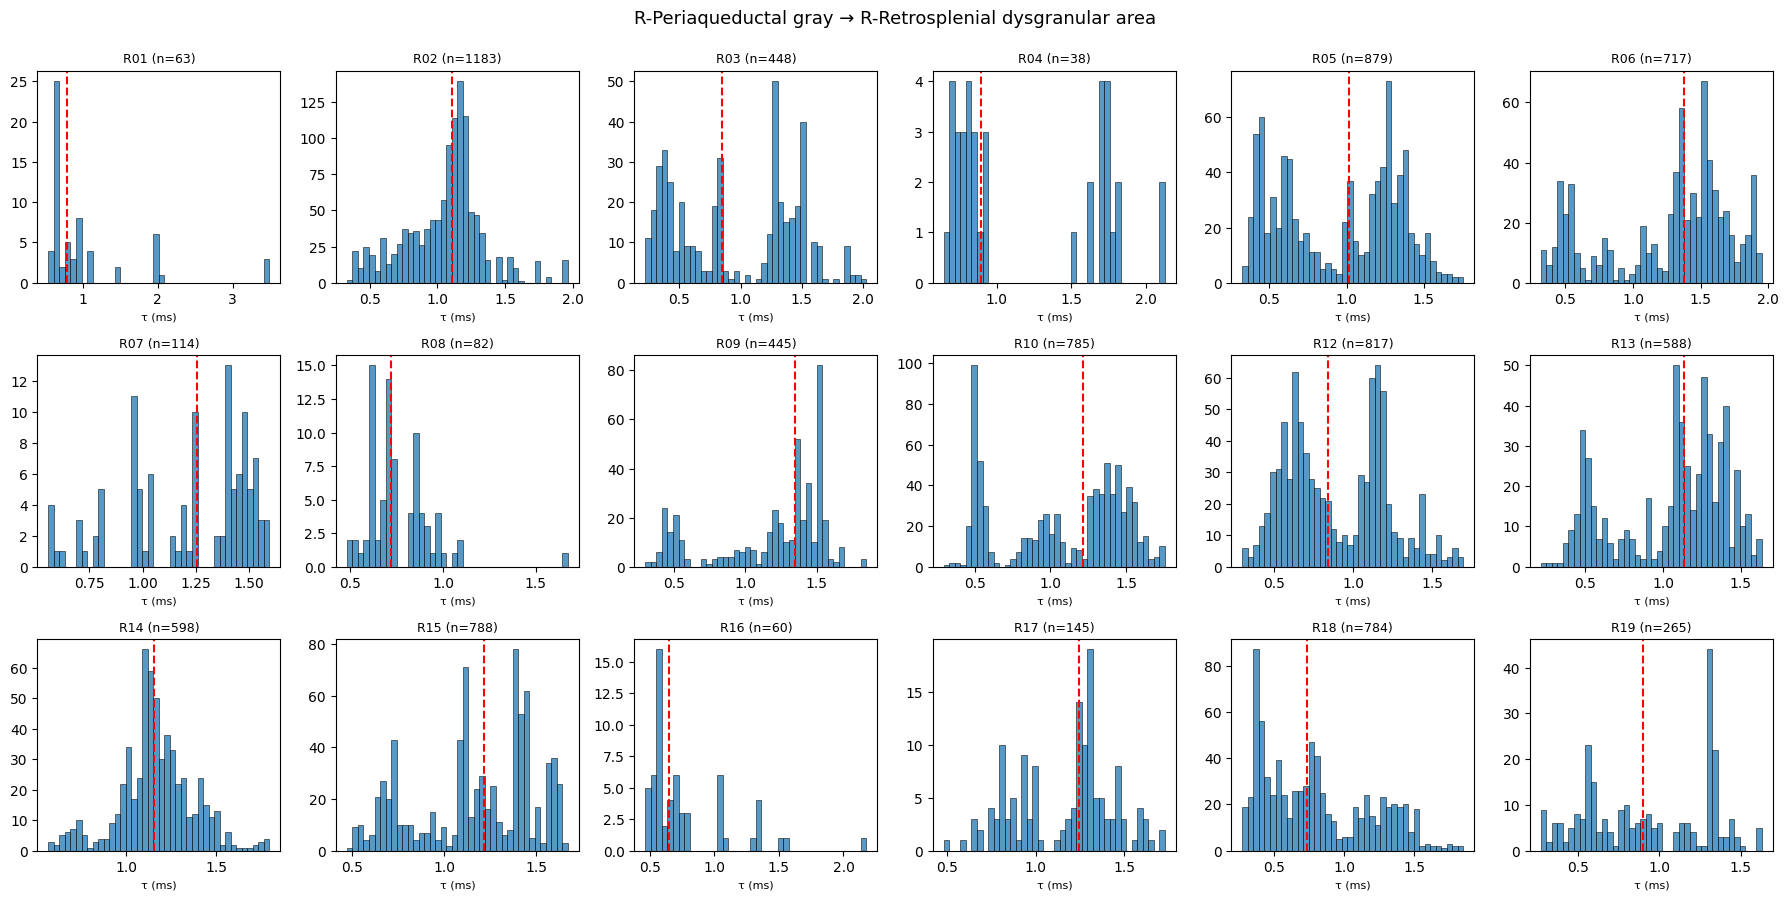

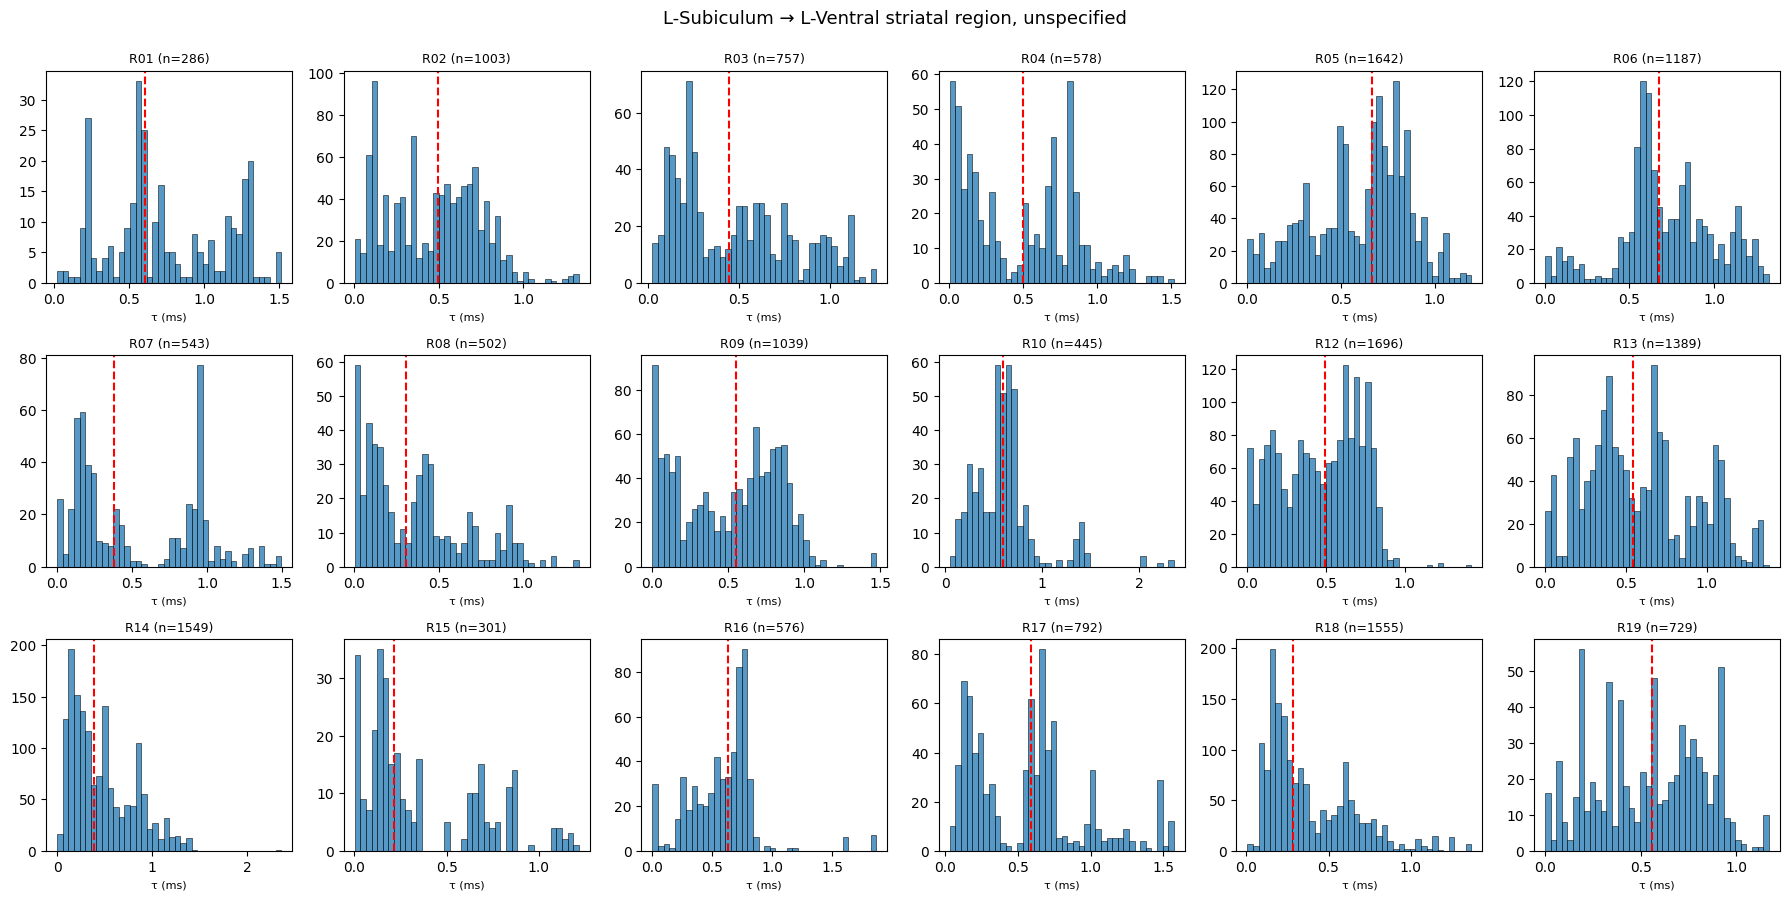

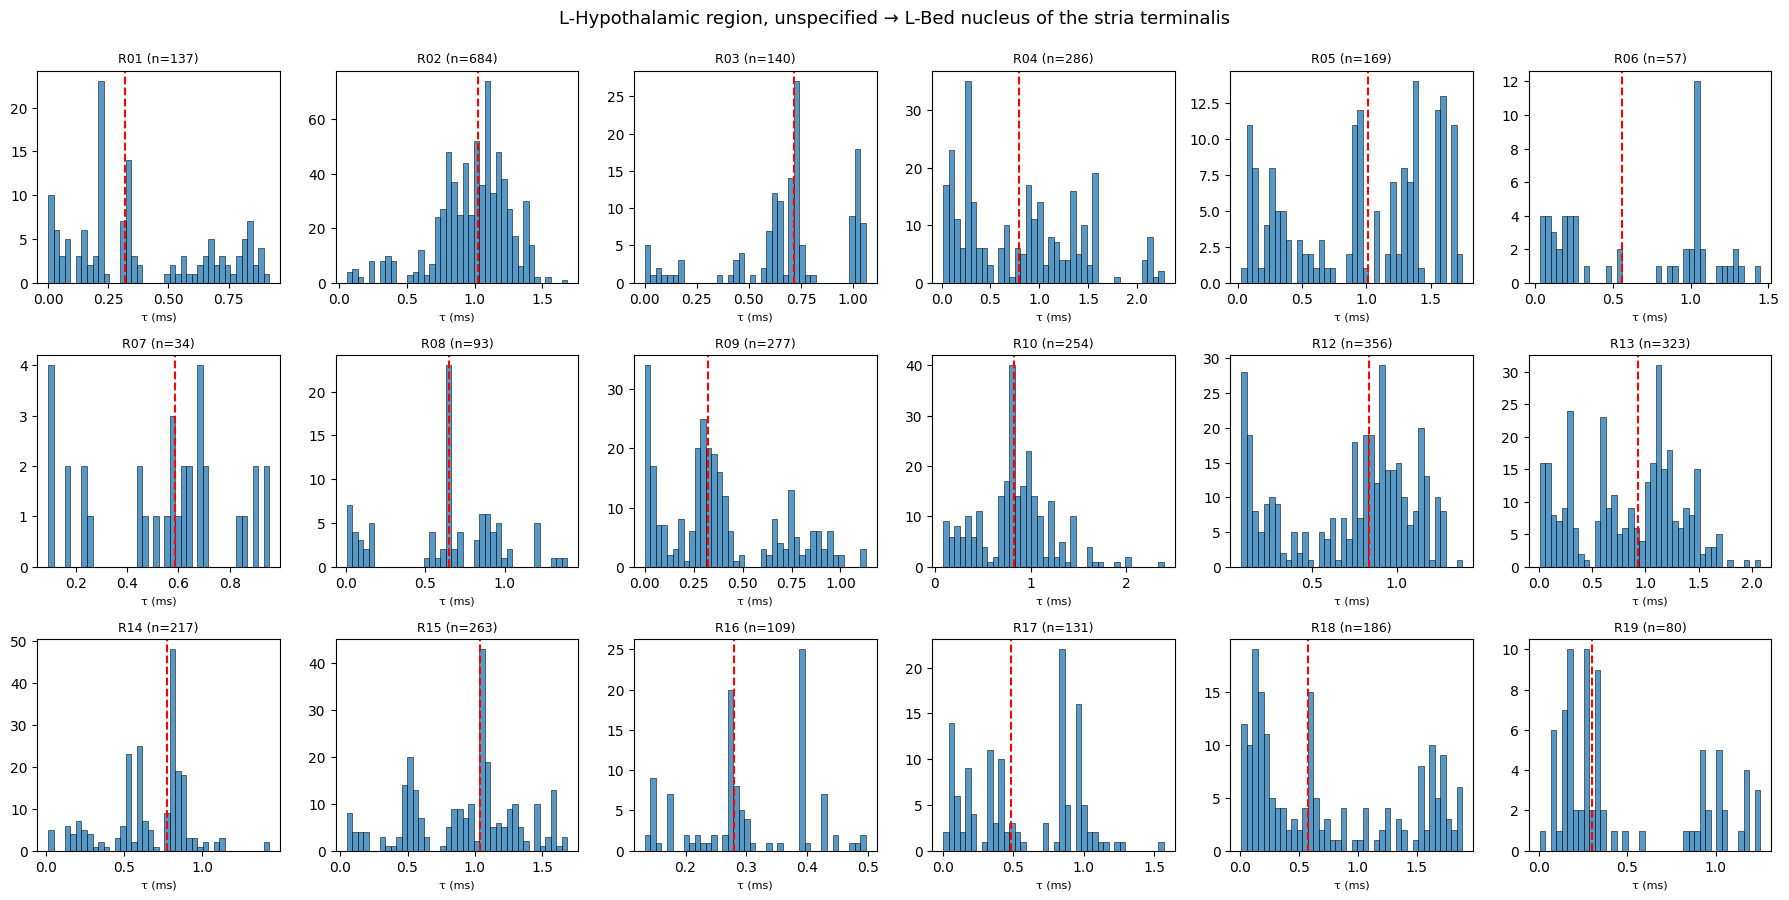

In [15]:
def plot_tau_distributions_multirat(cleaned_rats, pair, name_map, bins=50):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    axes = axes.ravel()
    
    for idx, (rat_id, data) in enumerate(sorted(cleaned_rats.items())):
        if pair not in data:
            axes[idx].text(0.5, 0.5, 'N/A', ha='center', va='center')
            axes[idx].set_title(rat_id)
            axes[idx].axis('off')
            continue
        
        tau_ms = data[pair][:, COL_TAU] * 1e3
        axes[idx].hist(tau_ms, bins=bins, alpha=0.75, edgecolor='k', linewidth=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=1.5)
        axes[idx].set_title(f"{rat_id} (n={len(tau_ms)})", fontsize=9)
        axes[idx].set_xlabel('τ (ms)', fontsize=8)
    
    i, j = pair
    fig.suptitle(f"{roi_label(i, name_map)} → {roi_label(j, name_map)}", fontsize=13, y=0.995)
    plt.tight_layout()
    return fig

# Top 3
for idx in [0, 1, 2]:
    row = df_stable_diverse.iloc[idx]
    pair = (row['roi_i'], row['roi_j'])
    plot_tau_distributions_multirat(cleaned_rats, pair, name_map, bins=40)
    plt.show()

In [16]:
# Diversificar por estabilidad y anatomía
final_candidates = df_stable_diverse[
    df_stable_diverse['pair_label'].isin([
        'L-Hypothalamic region, unspecified → L-Bed nucleus of the stria terminalis',  # estable, alto n
        'R-Peri-Subiculum → R-Periaqueductal gray',  # heterogéneo (bimodal)
        'L-Hippocampus → L-Hypothalamic region, unspecified',  # estable, alto rango
        'R-Periaqueductal gray → R-Retrosplenial dysgranular area',  # alto n (4965)
        'L-Subiculum → L-Ventral striatal region, unspecified',  # altísimo n (5951)
        'R-Subiculum → R-Periaqueductal gray',  # consistente, n alto
        'L-Zona incerta → L-Hypothalamic region, unspecified',  # corto pero amplio rango
    ])
]
final_candidates

,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
275,114,132,R-Periaqueductal gray → R-Retrosplenial dysgra...,18,1.025387,0.225099,0.219526,1.517161,488.833333,6.519233,intra
102,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",18,0.495798,0.131054,0.264329,1.499453,920.500000,2.882681,intra
142,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",18,0.668373,0.249705,0.373602,1.453397,210.888889,4.265418,intra
244,107,114,R-Subiculum → R-Periaqueductal gray,18,1.080194,0.201262,0.186320,1.422807,582.222222,6.743588,intra
90,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",13,0.810603,0.274912,0.339144,1.355127,161.000000,5.383397,intra
236,103,114,R-Peri-Subiculum → R-Periaqueductal gray,15,0.488677,0.184062,0.376653,1.082992,162.733333,3.081043,intra
13,9,35,"L-Zona incerta → L-Hypothalamic region, unspec...",18,0.221485,0.085906,0.387861,1.039295,582.111111,1.396180,intra


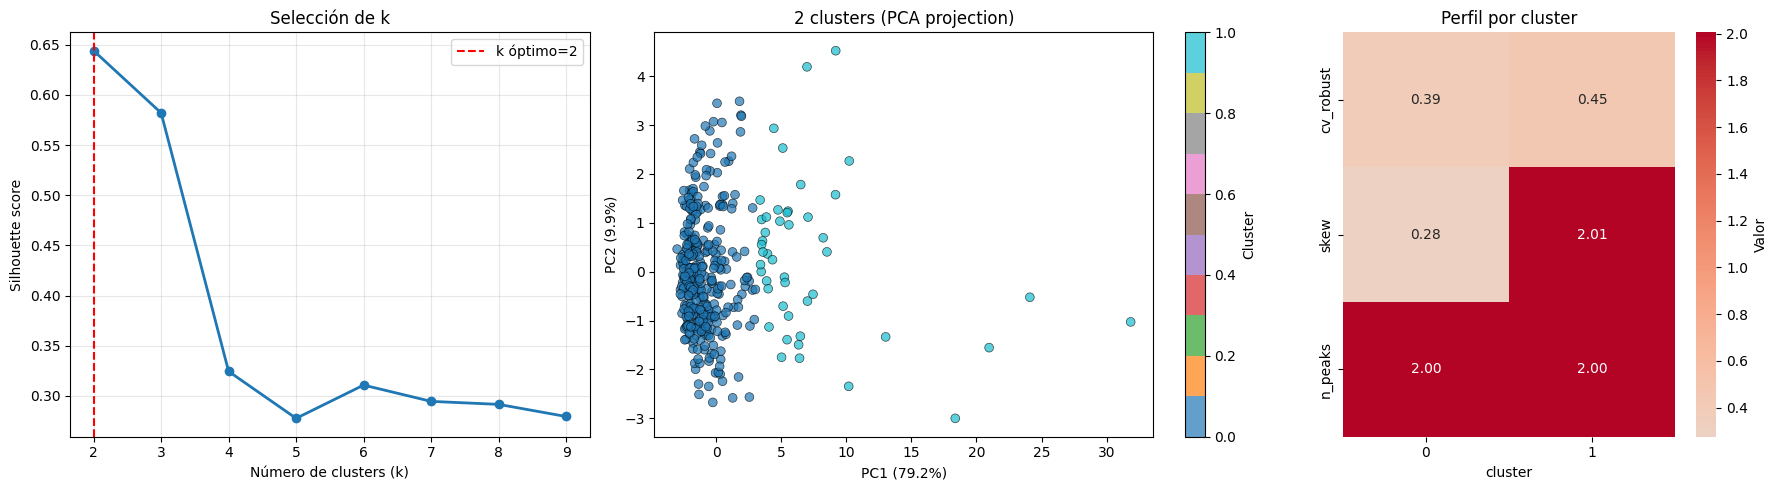


k óptimo: 2 | Silhouette: 0.644

Distribución: {0: 340, 1: 46}


In [43]:
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import entropy
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wasserstein_distance

def characterize_distributions_enhanced(cleaned_rats, pairs_list):
    """Features + divergencias vs referencia"""
    rows = []
    
    # 1er paso: construir distribución de referencia (pooled)
    all_tau = []
    for rat_id, data in cleaned_rats.items():
        for (i, j) in pairs_list:
            if (i, j) in data:
                all_tau.append(data[(i,j)][:, COL_TAU] * 1e3)
    ref_tau = np.concatenate(all_tau)
    ref_hist, ref_edges = np.histogram(ref_tau, bins=50, density=True)
    ref_cdf = np.cumsum(ref_hist) / ref_hist.sum()
    
    # 2do paso: caracterizar cada distribución
    for rat_id, data in cleaned_rats.items():
        for (i, j) in pairs_list:
            if (i, j) not in data:
                continue
            
            tau_ms = data[(i,j)][:, COL_TAU] * 1e3
            
            # Histogram
            hist, edges = np.histogram(tau_ms, bins='auto', density=True)
            peaks, _ = find_peaks(hist, prominence=hist.max()*0.1)
            
            # Métricas de forma
            g1 = stats.skew(tau_ms)
            g2 = stats.kurtosis(tau_ms, fisher=True)
            bimodality_coef = (g1**2 + 1) / (g2 + 3)
            
            hist_prob = hist / hist.sum()
            shannon_entropy = entropy(hist_prob[hist_prob > 0])
            
            # Robustez
            med = np.median(tau_ms)
            mad = np.median(np.abs(tau_ms - med))
            cv_robust = 1.4826 * mad / med if med > 0 else np.nan
            
            # Divergencias vs referencia
            wassers_dist = wasserstein_distance(tau_ms, ref_tau)
            ks_stat, _ = stats.ks_2samp(tau_ms, ref_tau)
            
            # KL divergence (discretizada, evita log(0))
            hist_sample, _ = np.histogram(tau_ms, bins=ref_edges, density=True)
            hist_sample = hist_sample / hist_sample.sum()
            # Añadir epsilon para evitar log(0)
            eps = 1e-10
            kl_div = entropy(hist_sample + eps, ref_hist + eps)
            
            rows.append({
                'rat_id': rat_id, 'roi_i': i, 'roi_j': j,
                'pair_label': f"{roi_label(i, name_map)} → {roi_label(j, name_map)}",
                'n': len(tau_ms),
                'mean': tau_ms.mean(),
                'median': med,
                'cv_robust': cv_robust,
                'skew': g1,
                'kurt': g2,
                'bimodality_coef': bimodality_coef,
                'n_peaks': len(peaks),
                'entropy': shannon_entropy,
                'range_norm': np.ptp(tau_ms) / tau_ms.mean(),
                'iqr_norm': stats.iqr(tau_ms) / tau_ms.mean(),
                'wasserstein': wassers_dist,
                'ks_stat': ks_stat,
                'kl_div': kl_div
            })
    
    return pd.DataFrame(rows)


# Caracterizar
top_pairs = [(r['roi_i'], r['roi_j']) for _, r in df_stable_diverse.head(50).iterrows()]
df_feat = characterize_distributions_enhanced(cleaned_rats, top_pairs)

# Features para clustering (robustos a outliers)
X = df_feat[['cv_robust', 'skew', 'bimodality_coef', 'iqr_norm', 'wasserstein', 'ks_stat', 'mean', 'median', 'kurt', 'n_peaks', 'entropy', 'kl_div', 'range_norm']].values

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# PCA para visualización
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Determinar k óptimo (silhouette)
silhouette_scores = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=420, n_init=100)
    labels = kmeans.fit_predict(X_pca)
    silhouette_scores.append(silhouette_score(X_pca, labels))

# Clustering final con k óptimo
k_opt = K_range[np.argmax(silhouette_scores)]
kmeans_final = KMeans(n_clusters=k_opt, random_state=420, n_init=100)
df_feat['cluster'] = kmeans_final.fit_predict(X_pca)

# Visualización
fig = plt.figure(figsize=(18, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1.2, 0.8])

# 1) Silhouette scores
ax1 = fig.add_subplot(gs[0])
ax1.plot(K_range, silhouette_scores, 'o-', linewidth=2)
ax1.axvline(k_opt, color='r', ls='--', label=f'k óptimo={k_opt}')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Silhouette score')
ax1.set_title('Selección de k')
ax1.legend(); ax1.grid(alpha=0.3)

# 2) PCA con clusters
ax2 = fig.add_subplot(gs[1])
scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=df_feat['cluster'], 
                      cmap='tab10', s=40, alpha=0.7, edgecolors='k', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax2.set_title(f'{k_opt} clusters (PCA projection)')
plt.colorbar(scatter, ax=ax2, label='Cluster')

# 3) Resumen por cluster
ax3 = fig.add_subplot(gs[2])
cluster_summary = df_feat.groupby('cluster')[['cv_robust', 'skew', 'n_peaks']].median()
sns.heatmap(cluster_summary.T, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax3, cbar_kws={'label': 'Valor'})
ax3.set_title('Perfil por cluster')

plt.tight_layout()
plt.show()

print(f"\nk óptimo: {k_opt} | Silhouette: {max(silhouette_scores):.3f}")
print(f"\nDistribución: {df_feat['cluster'].value_counts().sort_index().to_dict()}")

In [37]:
df_feat.head(10)

,rat_id,roi_i,roi_j,pair_label,n,mean,median,cv_robust,skew,kurt,bimodality_coef,n_peaks,entropy,range_norm,iqr_norm,wasserstein,ks_stat,kl_div,cluster
0,R05,114,132,R-Periaqueductal gray → R-Retrosplenial dysgra...,879,0.945179,1.017499,0.503032,-0.059403,-1.468568,0.655288,1,2.198229,1.513330,0.742017,0.330644,0.377940,0.725096,1
1,R05,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",1642,0.601226,0.664981,0.380554,-0.407326,-0.573435,0.480479,5,2.738008,1.988643,0.610317,0.095077,0.125826,0.210316,1
2,R05,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",169,0.957821,1.015211,0.771539,-0.289413,-1.347782,0.655943,2,2.060856,1.789076,1.067770,0.344656,0.423009,1.086087,1
3,R05,107,114,R-Subiculum → R-Periaqueductal gray,980,1.018206,1.113533,0.210399,-0.745841,-0.205372,0.556882,1,2.690261,1.392185,0.349453,0.404015,0.525274,0.869641,1
4,R05,9,42,L-Zona incerta → L-Bed nucleus of the stria te...,448,0.653470,0.613722,0.508973,0.473001,-0.269221,0.448125,2,2.215186,2.074963,0.576447,0.100531,0.185643,0.390474,1
5,R05,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",277,0.891869,0.698093,0.594066,0.338100,-1.444679,0.716451,2,2.069759,1.694933,0.987301,0.277130,0.272580,0.728057,1
6,R05,112,114,"R-Brainstem, unspecified → R-Periaqueductal gray",379,0.834477,0.870018,0.341862,-0.366438,-0.532976,0.459775,3,2.327792,1.779805,0.451531,0.224631,0.392245,0.545025,1
7,R05,35,53,"L-Hypothalamic region, unspecified → L-Ventral...",244,0.874879,0.770533,0.385997,0.726923,-0.767284,0.684555,2,2.010393,1.429441,0.559657,0.261434,0.361937,0.727064,1
8,R05,29,63,L-Subiculum → L-Nucleus of the lateral olfacto...,581,0.293811,0.307626,0.891479,0.067573,-1.102473,0.529408,1,2.149381,2.629663,1.238525,0.321722,0.460974,0.695518,1
9,R05,108,132,R-Subthalamic nucleus → R-Retrosplenial dysgra...,383,0.376487,0.272606,0.940576,0.652263,-0.172231,0.504089,2,1.819055,3.162274,1.156930,0.242667,0.347464,0.633253,1


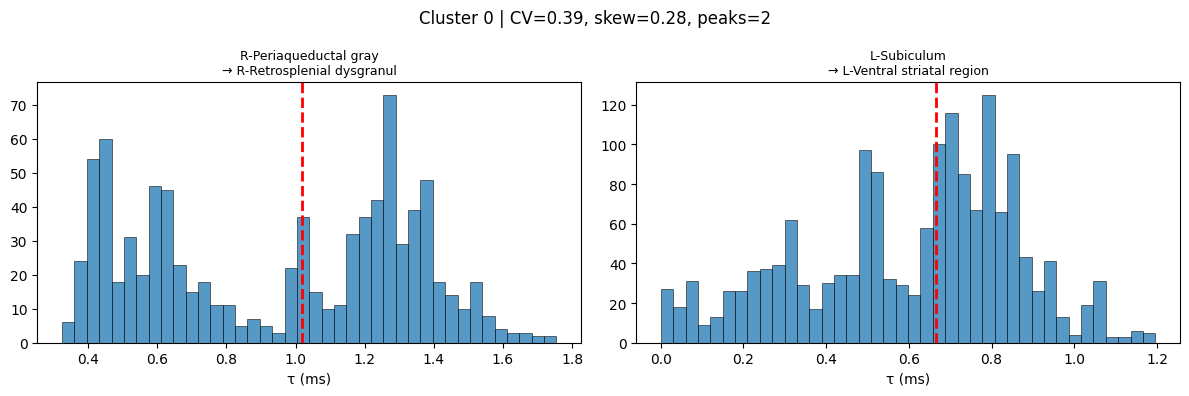

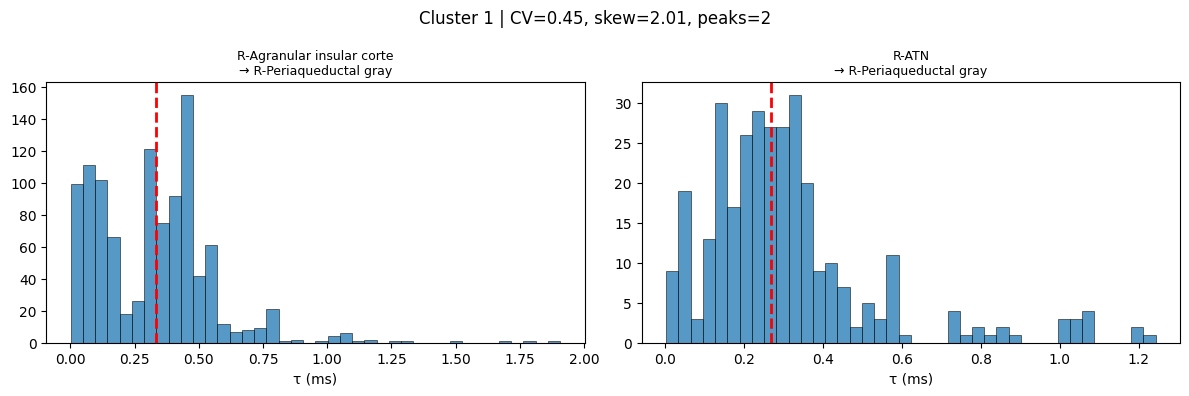

In [44]:
# 2 ejemplos por cluster
np.random.seed(42)
for c in sorted(df_feat['cluster'].unique()):
    # Tomar 2 pares distintos del cluster
    cluster_pairs = df_feat[df_feat['cluster'] == c][['roi_i', 'roi_j', 'rat_id']].drop_duplicates(['roi_i', 'roi_j']).head(2)
    
    if len(cluster_pairs) == 0:
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    cluster_profile = df_feat[df_feat['cluster'] == c][['cv_robust', 'skew', 'n_peaks']].median()
    
    for idx, (_, row) in enumerate(cluster_pairs.iterrows()):
        i, j, rat = int(row['roi_i']), int(row['roi_j']), row['rat_id']
        tau_ms = cleaned_rats[rat][(i,j)][:, COL_TAU] * 1e3
        
        axes[idx].hist(tau_ms, bins=40, alpha=0.75, edgecolor='k', linewidth=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=2)
        axes[idx].set_title(f"{roi_label(i, name_map)[:25]}\n→ {roi_label(j, name_map)[:25]}", fontsize=9)
        axes[idx].set_xlabel('τ (ms)')
    
    fig.suptitle(f'Cluster {c} | CV={cluster_profile["cv_robust"]:.2f}, skew={cluster_profile["skew"]:.2f}, peaks={cluster_profile["n_peaks"]:.0f}', fontsize=12)
    plt.tight_layout()
    plt.show()